In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras.models import load_model
from my_batch_normalization import MyBatchNormalization
from layers import BilinearUpSampling2D

Using TensorFlow backend.


In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

## Загрузка моделей

In [7]:
def mean_relative_squared_error(groundtruth, prediction):
    return tf.reduce_mean((prediction - groundtruth) ** 2 / groundtruth ** 2)

def relative_error(groundtruth, prediction):
    print(prediction, groundtruth)
    return tf.reduce_mean(tf.abs(prediction - groundtruth) / tf.maximum(groundtruth, 0.5))

In [8]:
our_model = load_model('models/resnet_with_shortcuts_nonbt_320x240.hdf5', 
                   custom_objects={'MyBatchNormalization': MyBatchNormalization,
                                   'mean_relative_squared_error': mean_relative_squared_error,
                                   'relative_error': relative_error}
                  )

/home/kmouraviev/anaconda/envs/tensorflow_py36_1/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
our_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 160, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
my_batch_normalization_1 (MyBat (None, 120, 160, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [10]:
densedepth_model = load_model('models/densedepth.h5',
                              custom_objects={'BilinearUpSampling2D': BilinearUpSampling2D}
                             )

In [11]:
densedepth_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block12_2_conv (Conv2D)   (None, None, None, 3 36864       conv5_block12_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block12_concat (Concatena (None, None, None, 1 0           conv5_block11_concat[0][0]       
                                                                 conv5_block12_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block13_0_bn (BatchNormal (None, None, None, 1 4096        conv5_block12_concat[0][0]       
__________________________________________________________________________________________________
conv5_block13_0_relu (Activatio (None, None, None, 1 0           conv5_block13_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block13_1_conv (Conv2D)   (None, None, None, 1 131072      conv5_block13_0_relu[0][0]       
__________

## Evaluation, short corridor

In [12]:
import h5py
f = h5py.File('first_floor_images.hdf5', 'r')
rgbs = np.array(f['rgb'])
depths = np.array(f['depth'])

In [13]:
from skimage.transform import resize

In [14]:
from tqdm import tqdm_notebook

In [15]:
rgbs_640x480 = np.array([resize(img, (480, 640, 3)) for img in tqdm_notebook(rgbs)])

/home/kmouraviev/anaconda/envs/tensorflow_py36_1/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/kmouraviev/anaconda/envs/tensorflow_py36_1/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [16]:
depths_640x480 = np.array([resize(img, (480, 640)) for img in tqdm_notebook(depths)])

In [17]:
with h5py.File('first_floor_images_640x480.hdf5', 'w') as f:
    f.create_dataset('rgb', data=rgbs_640x480)
    f.create_dataset('depth', data=depths_640x480)

In [24]:
rgbs_preprocessed = rgbs.copy().astype(np.float64)
rgbs_preprocessed[:, :, :, 0] -= 103
rgbs_preprocessed[:, :, :, 1] -= 115
rgbs_preprocessed[:, :, :, 2] -= 123
print(rgbs_preprocessed.min(), rgbs_preprocessed.max())

-123.0 147.0


In [25]:
densedepth_prediction = 10.0 / densedepth_model.predict(rgbs_640x480, batch_size=4)[..., 0]
our_prediction = our_model.predict(rgbs_preprocessed, batch_size=4)

In [26]:
densedepth_mse = np.mean((densedepth_prediction - depths) ** 2)
densedepth_rel = np.mean(np.abs(densedepth_prediction - depths) / np.maximum(depths, 0.5))

In [27]:
our_mse = np.mean((our_prediction - depths) ** 2)
our_rel = np.mean(np.abs(our_prediction - depths) / np.maximum(depths, 0.5))

In [28]:
print('DenseDepth model evaluation:')
print('MSE:', densedepth_mse)
print('Relative error:', densedepth_rel)

DenseDepth model evaluation:
MSE: 0.65333277
Relative error: 0.32338858


In [29]:
print('Our model evaluation:')
print('MSE:', our_mse)
print('Relative error:', our_rel)

Our model evaluation:
MSE: 0.79215693
Relative error: 0.33716097


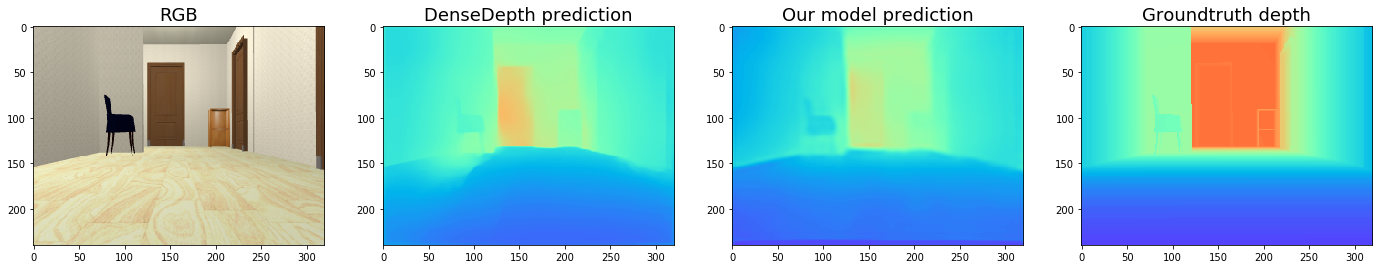

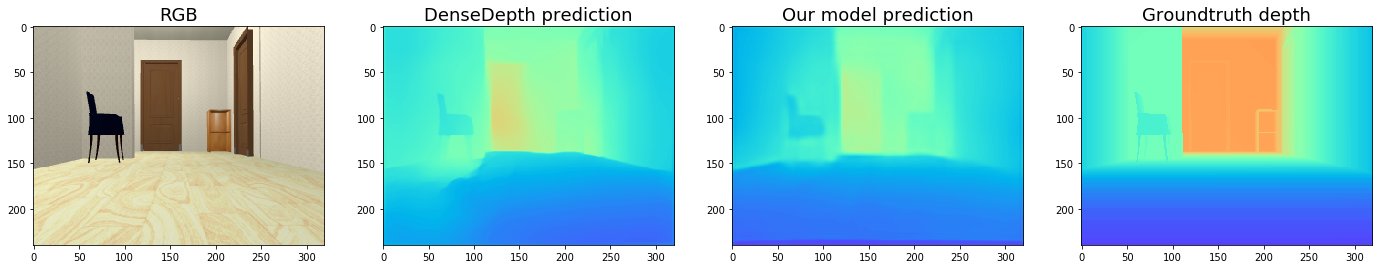

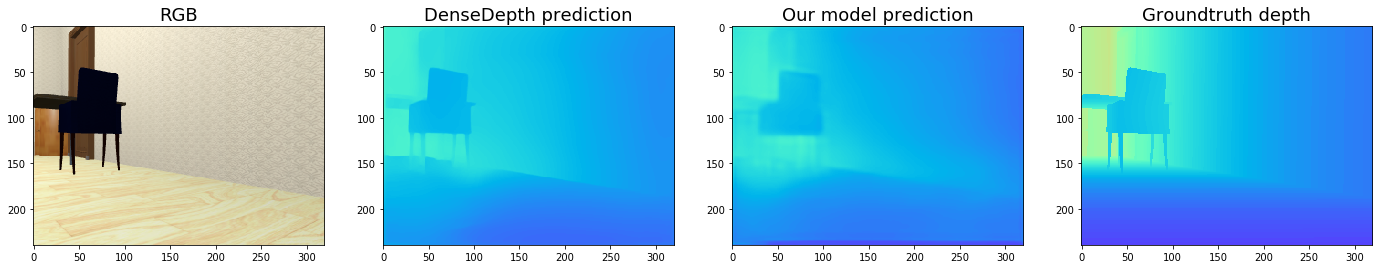

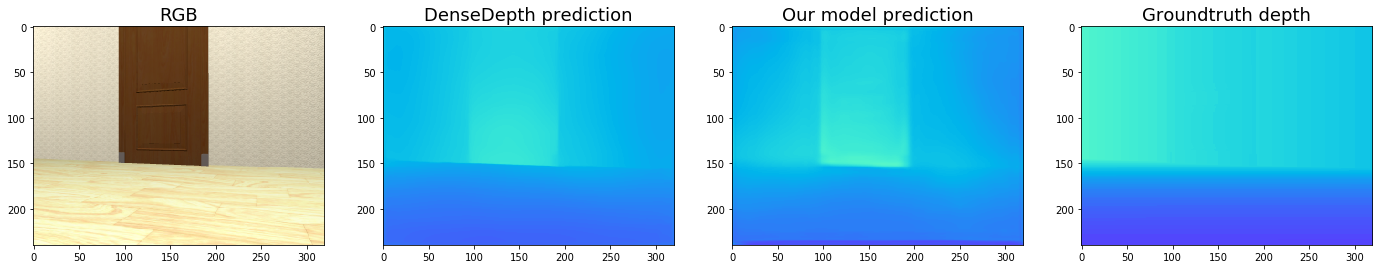

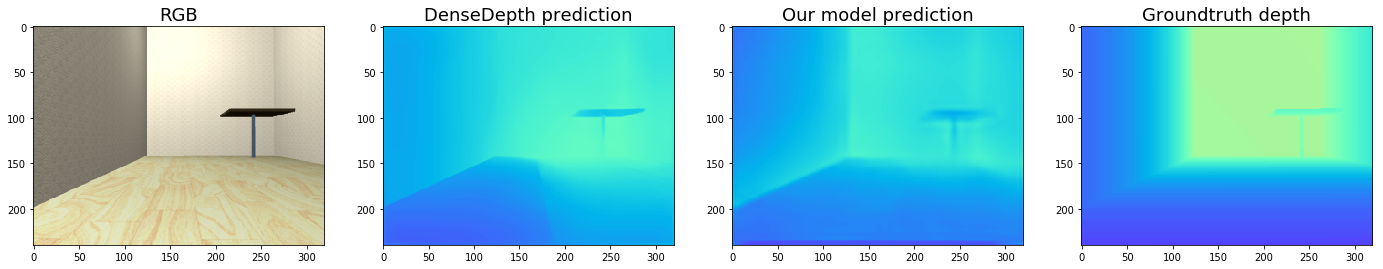

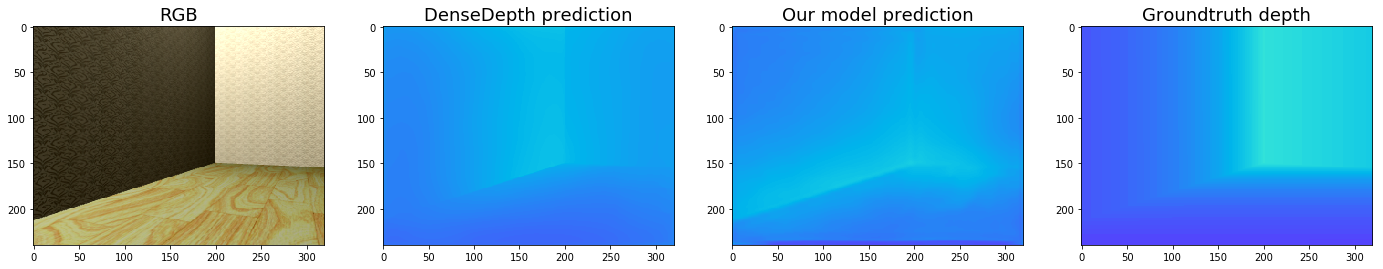

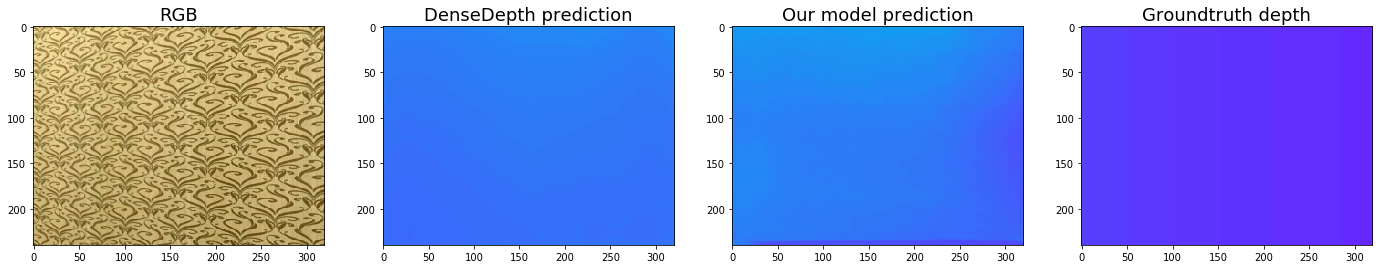

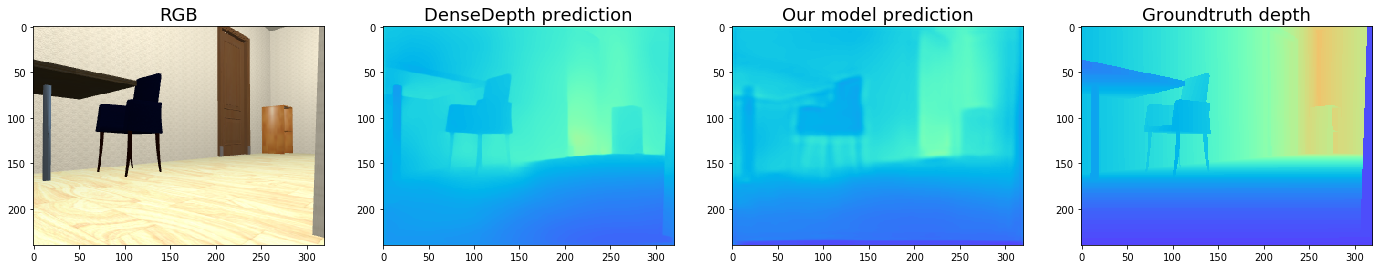

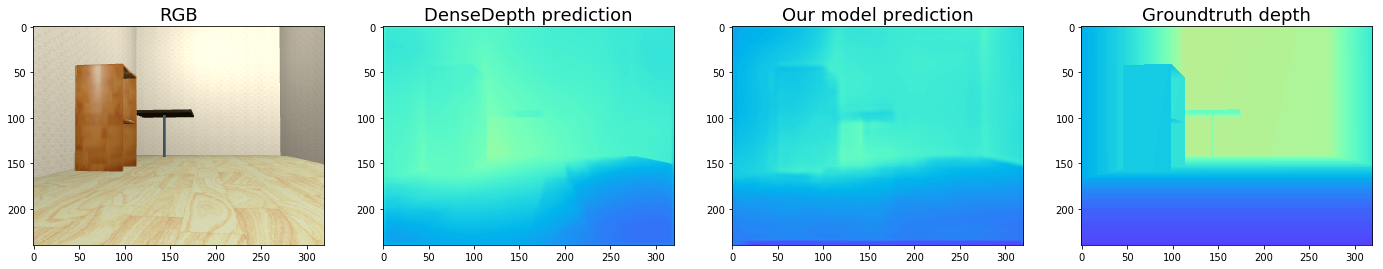

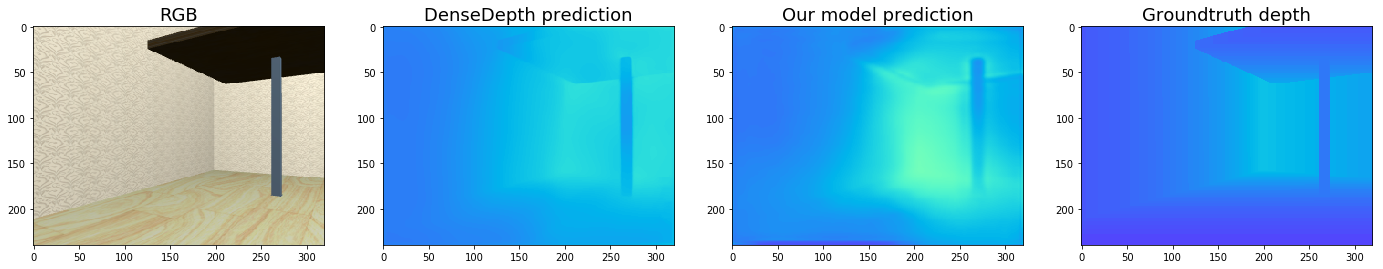

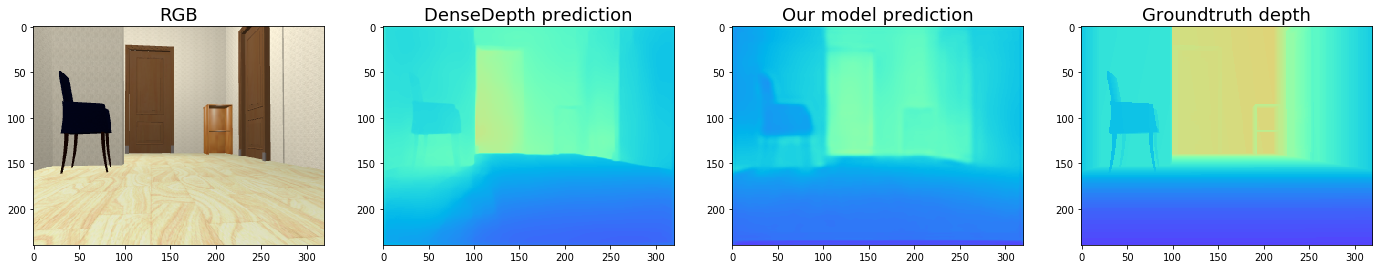

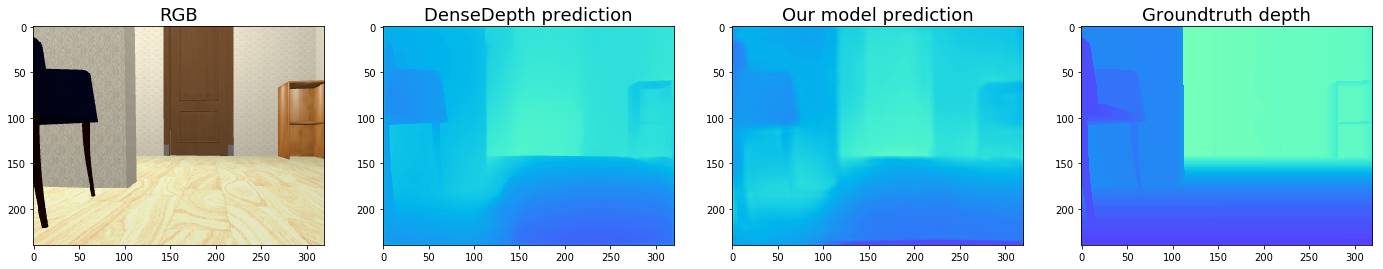

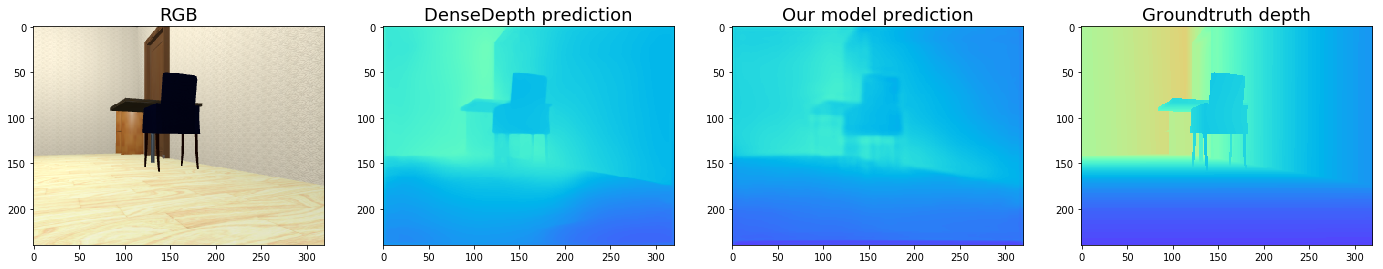

In [30]:
for i in range(1, rgbs.shape[0], 200):
    plt.figure(figsize=(24, 5))
    plt.subplot(1, 4, 1)
    plt.title('RGB', fontsize=18)
    plt.imshow(rgbs[i, :, :, ::-1])
    plt.subplot(1, 4, 2)
    plt.title('DenseDepth prediction', fontsize=18)
    plt.imshow(densedepth_prediction[i], cmap='rainbow', vmin=0, vmax=8)
    plt.subplot(1, 4, 3)
    plt.title('Our model prediction', fontsize=18)
    plt.imshow(our_prediction[i], cmap='rainbow', vmin=0, vmax=8)
    plt.subplot(1, 4, 4)
    plt.title('Groundtruth depth', fontsize=18)
    plt.imshow(depths[i], cmap='rainbow', vmin=0, vmax=8)
    plt.show()

## Evaluation, long corridor

In [42]:
ff = h5py.File('second_floor_images.hdf5', 'r')
rgbs = np.array(ff['rgb'])
depths = np.array(ff['depth'])

In [43]:
rgbs_640x480 = np.array([resize(img, (480, 640, 3)) for img in tqdm_notebook(rgbs)])

In [44]:
rgbs_preprocessed = rgbs.copy().astype(np.float64)
rgbs_preprocessed[:, :, :, 0] -= 103
rgbs_preprocessed[:, :, :, 1] -= 115
rgbs_preprocessed[:, :, :, 2] -= 123
print(rgbs_preprocessed.min(), rgbs_preprocessed.max())

-123.0 152.0


In [45]:
densedepth_prediction = 10.0 / densedepth_model.predict(rgbs_640x480, batch_size=4)[..., 0]
our_prediction = our_model.predict(rgbs_preprocessed, batch_size=4)

In [46]:
densedepth_mse = np.mean((densedepth_prediction - depths) ** 2)
densedepth_rel = np.mean(np.abs(densedepth_prediction - depths) / np.maximum(depths, 0.5))

In [47]:
our_mse = np.mean((our_prediction - depths) ** 2)
our_rel = np.mean(np.abs(our_prediction - depths) / np.maximum(depths, 0.5))

In [48]:
print('DenseDepth model evaluation:')
print('MSE:', densedepth_mse)
print('Relative error:', densedepth_rel)

DenseDepth model evaluation:
MSE: 2.2597594
Relative error: 0.3592731


In [49]:
print('Our model evaluation:')
print('MSE:', our_mse)
print('Relative error:', our_rel)

Our model evaluation:
MSE: 2.1702528
Relative error: 0.31070274


In [53]:
(depths > 9.5).mean()

0.04081725119396811

In [74]:
print('DenseDepth model:')
error = np.abs(densedepth_prediction - depths)
densedepth_rels = []
for d in np.linspace(1.0, 10.0, 19):
    target_error = error[np.logical_and((depths >= d), (depths < d + 0.5))]
    target_depths = depths[np.logical_and((depths >= d), (depths < d + 0.5))]
    rel = (target_error / target_depths).mean()
    densedepth_rels.append(rel)
    print('Rel error on depths {}-{}: {}'.format(d, d + 0.5, rel))

DenseDepth model:
Rel error on depths 1.0-1.5: 0.4725176692008972
Rel error on depths 1.5-2.0: 0.28598377108573914
Rel error on depths 2.0-2.5: 0.17616452276706696
Rel error on depths 2.5-3.0: 0.13311684131622314
Rel error on depths 3.0-3.5: 0.15657350420951843
Rel error on depths 3.5-4.0: 0.19802312552928925
Rel error on depths 4.0-4.5: 0.2391260862350464
Rel error on depths 4.5-5.0: 0.2779076099395752
Rel error on depths 5.0-5.5: 0.3036259114742279
Rel error on depths 5.5-6.0: 0.3186299502849579
Rel error on depths 6.0-6.5: 0.33763736486434937
Rel error on depths 6.5-7.0: 0.3551916778087616
Rel error on depths 7.0-7.5: 0.35730597376823425
Rel error on depths 7.5-8.0: 0.3622964024543762
Rel error on depths 8.0-8.5: 0.3621632754802704
Rel error on depths 8.5-9.0: 0.38001614809036255
Rel error on depths 9.0-9.5: 0.3819189667701721
Rel error on depths 9.5-10.0: 0.40731045603752136
Rel error on depths 10.0-10.5: 0.3653656244277954


In [75]:
print('Our model:')
error = np.abs(our_prediction - depths)
our_rels = []
for d in np.linspace(1.0, 10.0, 19):
    target_error = error[np.logical_and((depths >= d), (depths < d + 0.5))]
    target_depths = depths[np.logical_and((depths >= d), (depths < d + 0.5))]
    rel = (target_error / target_depths).mean()
    print('Rel error on depths {}-{}: {}'.format(d, d + 0.5, rel))
    our_rels.append(rel)

Our model:
Rel error on depths 1.0-1.5: 0.3575710356235504
Rel error on depths 1.5-2.0: 0.19050203263759613
Rel error on depths 2.0-2.5: 0.1254763901233673
Rel error on depths 2.5-3.0: 0.13754993677139282
Rel error on depths 3.0-3.5: 0.17617809772491455
Rel error on depths 3.5-4.0: 0.2206512838602066
Rel error on depths 4.0-4.5: 0.2579861879348755
Rel error on depths 4.5-5.0: 0.3004382252693176
Rel error on depths 5.0-5.5: 0.3353860080242157
Rel error on depths 5.5-6.0: 0.3338431119918823
Rel error on depths 6.0-6.5: 0.33531975746154785
Rel error on depths 6.5-7.0: 0.3388175964355469
Rel error on depths 7.0-7.5: 0.3370990455150604
Rel error on depths 7.5-8.0: 0.349831759929657
Rel error on depths 8.0-8.5: 0.36906641721725464
Rel error on depths 8.5-9.0: 0.3870626986026764
Rel error on depths 9.0-9.5: 0.40046244859695435
Rel error on depths 9.5-10.0: 0.4070962071418762
Rel error on depths 10.0-10.5: 0.34967634081840515


Text(0, 0.5, 'Error')

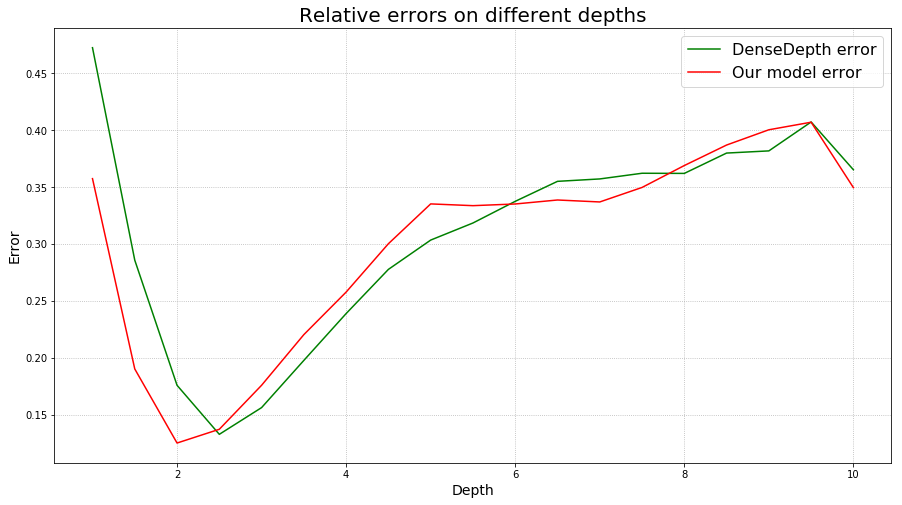

In [77]:
plt.figure(figsize=(15, 8))
plt.title('Relative errors on different depths', fontsize=20)
plt.grid(ls=':')
x = np.linspace(1.0, 10.0, 19)
plt.plot(x, densedepth_rels, color='g', label='DenseDepth error')
plt.plot(x, our_rels, color='r', label='Our model error')
plt.legend(fontsize=16)
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Error', fontsize=14)

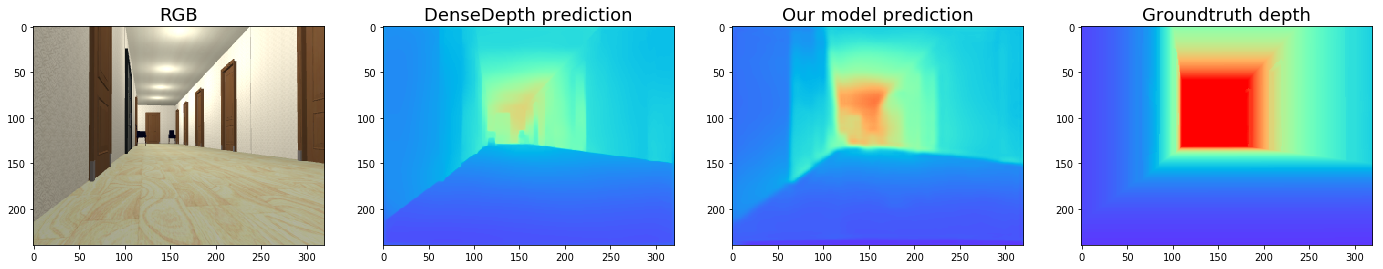

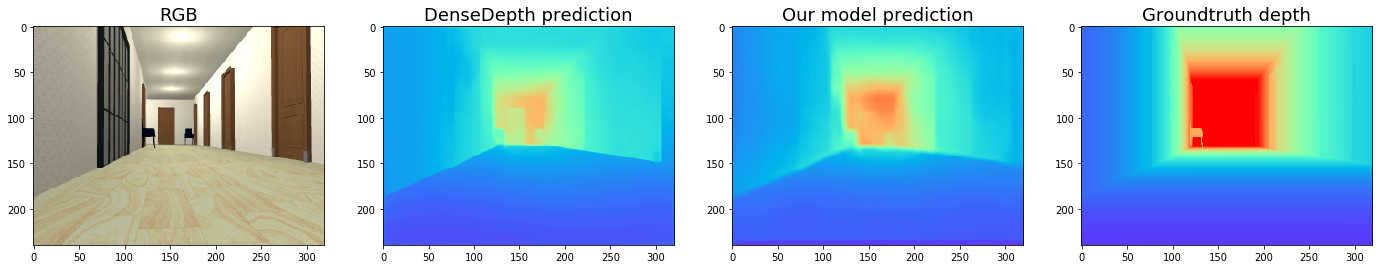

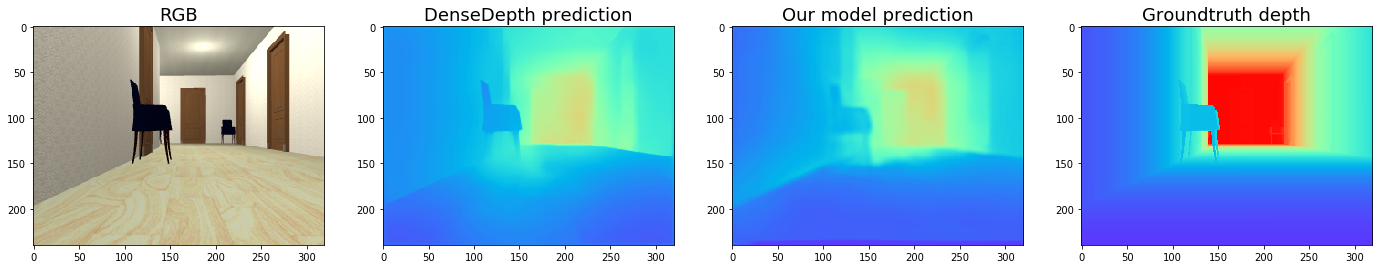

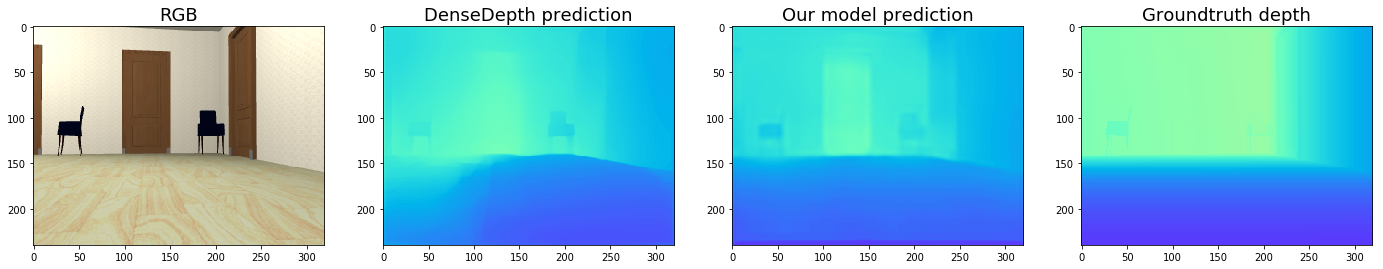

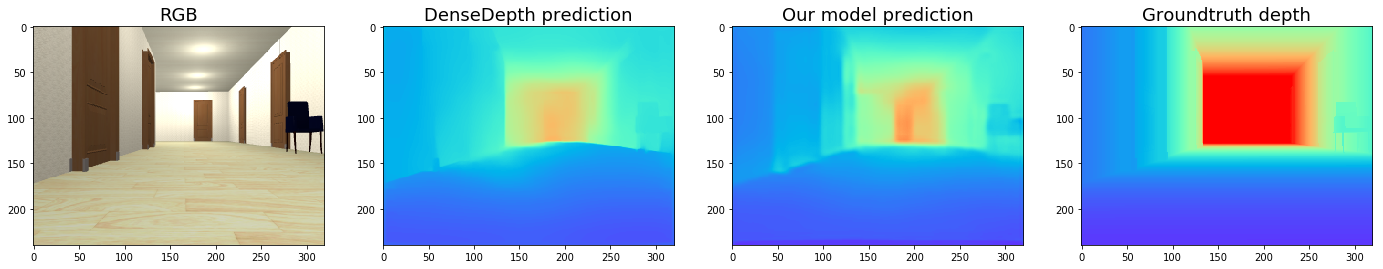

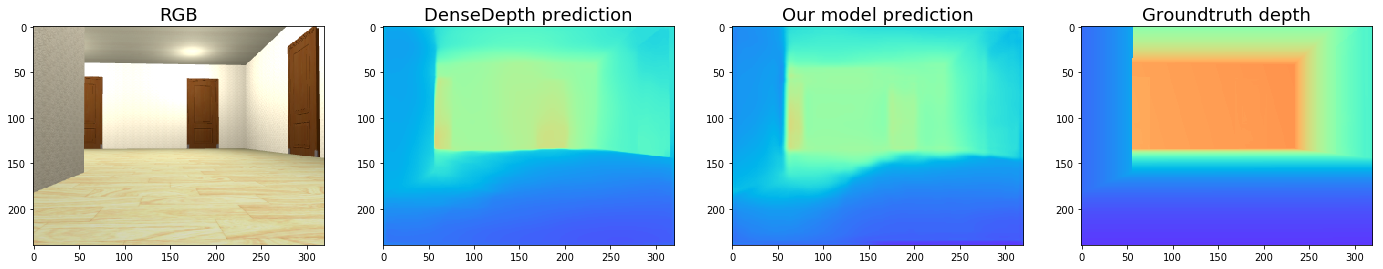

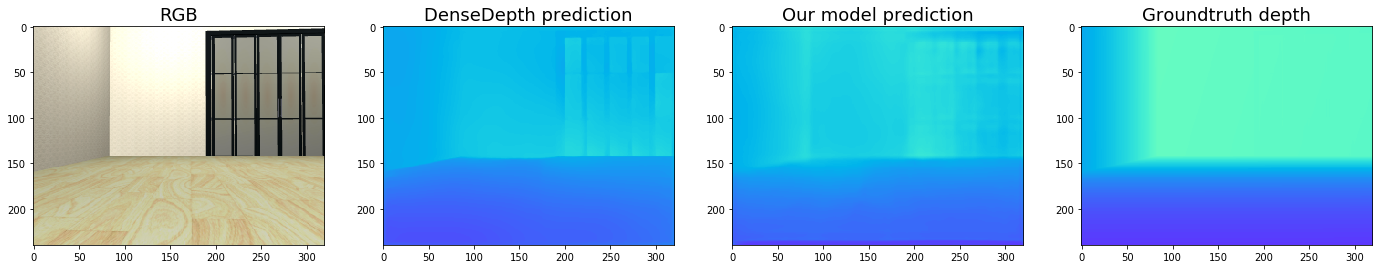

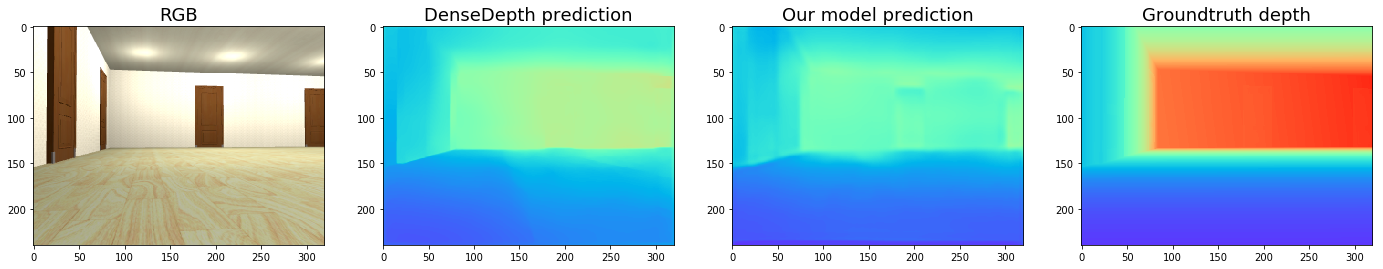

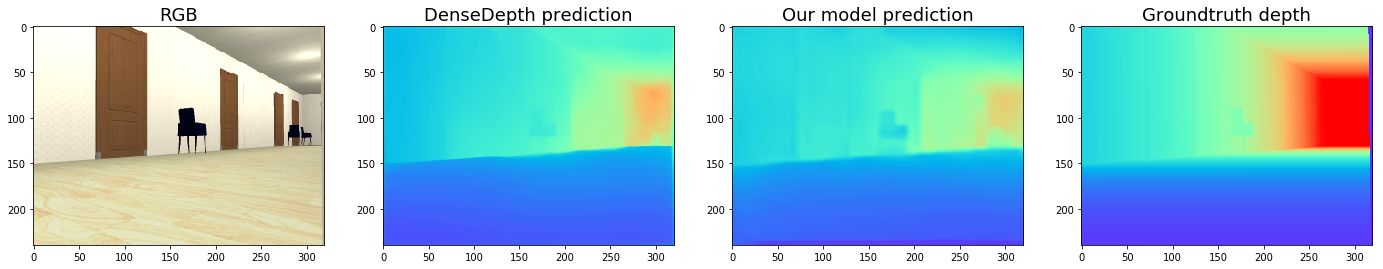

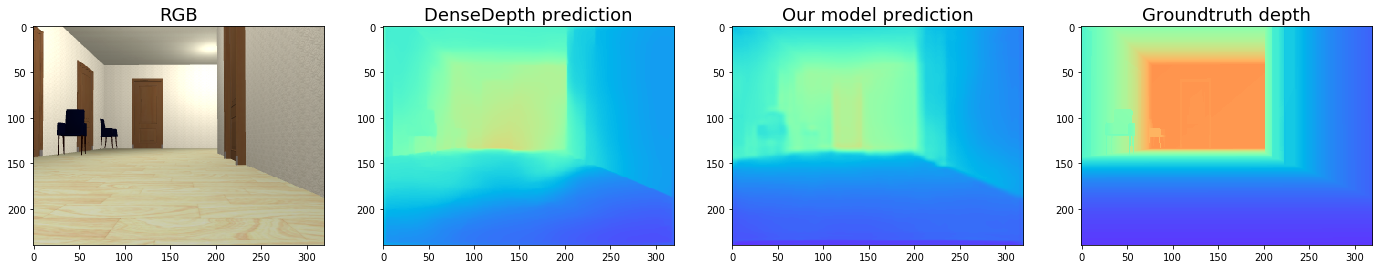

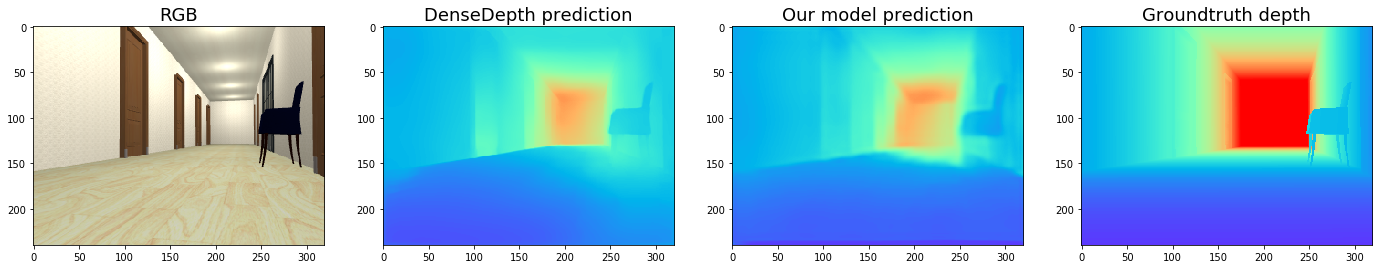

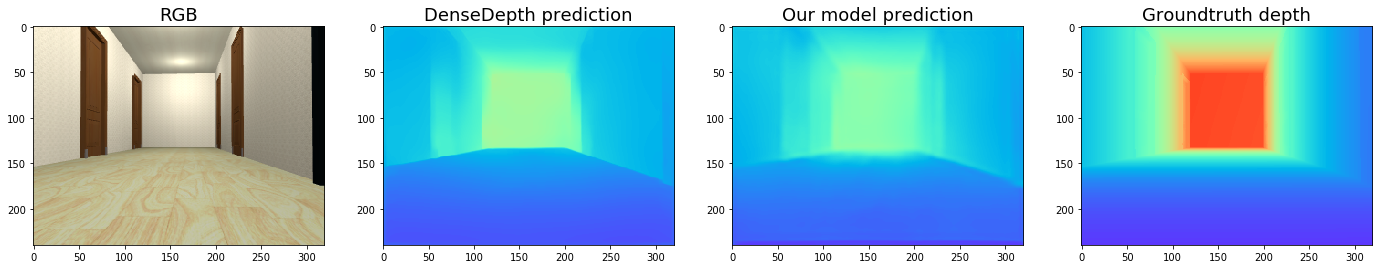

In [50]:
for i in range(1, rgbs.shape[0], 200):
    plt.figure(figsize=(24, 5))
    plt.subplot(1, 4, 1)
    plt.title('RGB', fontsize=18)
    plt.imshow(rgbs[i, :, :, ::-1])
    plt.subplot(1, 4, 2)
    plt.title('DenseDepth prediction', fontsize=18)
    plt.imshow(densedepth_prediction[i], cmap='rainbow', vmin=0, vmax=10)
    plt.subplot(1, 4, 3)
    plt.title('Our model prediction', fontsize=18)
    plt.imshow(our_prediction[i], cmap='rainbow', vmin=0, vmax=10)
    plt.subplot(1, 4, 4)
    plt.title('Groundtruth depth', fontsize=18)
    plt.imshow(depths[i], cmap='rainbow', vmin=0, vmax=10)
    plt.show()